### Framework and Data Loading

In [ ]:
%pip install transformers

In [ ]:
%pip install scikit-learn

In [ ]:
%pip install accelerate -U

In [ ]:
%pip install seaborn

In [1]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, matthews_corrcoef, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
from transformers import pipeline
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset

In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [6]:
# Load dataset
hatespeech = pd.read_csv('/Users/lauraguinandrodriguez/Desktop/Hate Speech/twits_25k_balanced.csv')

# Display the first few rows of the dataset
print(hatespeech.head())

      id  label                                              tweet
0   6088      0   who cares th ones a thirty dirty argentina &a...
1   5283      1   msnbc the same ms who said blocking flights f...
2  18442      0  it  i hate a bitch dat act like a night. &128530;
3   6715      0                          ha ha ha no good fat duke
4  13003      0  lynch mob thus threaten zimmerman jury; &8216;...


### Fine-Tuned Model

In [7]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(hatespeech, test_size=0.2, random_state=42)

In [8]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

class HateSpeechDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Tokenize the data
encodings = tokenizer(train_data['tweet'].tolist(), truncation=True, padding=True, max_length=128)

# Create the Torch dataset
dataset = HateSpeechDataset(encodings, train_data['label'].tolist())

In [1]:
pip install openai

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



     ---------------------------------------- 65.6/65.6 kB 1.8 MB/s eta 0:00:00
   ---------------------------------------- 212.1/212.1 kB 6.5 MB/s eta 0:00:00
   ---------------------------------------- 85.5/85.5 kB 5.0 MB/s eta 0:00:00
   ---------------------------------------- 75.9/75.9 kB 4.4 MB/s eta 0:00:00
   ---------------------------------------- 76.9/76.9 kB 4.4 MB/s eta 0:00:00
   ---------------------------------------- 381.9/381.9 kB 7.9 MB/s eta 0:00:00
   ---------------------------------------- 1.9/1.9 MB 7.5 MB/s eta 0:00:00


In [9]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset
)

# Fine-tune the model
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/645 [00:00<?, ?it/s]

{'loss': 1.1105, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.05}
{'loss': 1.0917, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.09}
{'loss': 1.09, 'learning_rate': 3e-06, 'epoch': 0.14}
{'loss': 1.1104, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.19}
{'loss': 1.0954, 'learning_rate': 5e-06, 'epoch': 0.23}
{'loss': 1.095, 'learning_rate': 6e-06, 'epoch': 0.28}
{'loss': 1.0645, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.33}
{'loss': 1.0632, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.37}
{'loss': 1.035, 'learning_rate': 9e-06, 'epoch': 0.42}
{'loss': 1.0234, 'learning_rate': 1e-05, 'epoch': 0.47}
{'loss': 0.9707, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.51}
{'loss': 0.9202, 'learning_rate': 1.2e-05, 'epoch': 0.56}
{'loss': 0.8844, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.6}
{'loss': 0.7973, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.65}
{'loss': 0.7884, 'learning_rate': 1.5e-05, 'epoch': 0.7}
{'loss': 0.7406, 'learning_ra

TrainOutput(global_step=645, training_loss=0.6119164782901143, metrics={'train_runtime': 427.786, 'train_samples_per_second': 24.068, 'train_steps_per_second': 1.508, 'train_loss': 0.6119164782901143, 'epoch': 3.0})

In [10]:
# Save the fine-tuned model
model.save_pretrained('/Users/lauraguinandrodriguez/Desktop/Hate Speech')

In [11]:
# Load the fine-tuned model
model = DistilBertForSequenceClassification.from_pretrained('/Users/lauraguinandrodriguez/Desktop/Hate Speech')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Function to make predictions
def predict(tweet, model, tokenizer):
    inputs = tokenizer(tweet, return_tensors="pt", truncation=True, padding=True, max_length=128)
    outputs = model(**inputs)
    probs = outputs.logits.softmax(dim=-1)
    return torch.argmax(probs, dim=-1).item()

# Make predictions
test_data['predicted_label'] = test_data['tweet'].apply(lambda x: predict(x, model, tokenizer))


In [16]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report, matthews_corrcoef

# Calculate metrics
accuracy = accuracy_score(test_data['label'], test_data['predicted_label'])
precision, recall, f1, _ = precision_recall_fscore_support(test_data['label'], test_data['predicted_label'], average='weighted')
conf_matrix = confusion_matrix(test_data['label'], test_data['predicted_label'])
report = classification_report(test_data['label'], test_data['predicted_label'])
mcc = matthews_corrcoef(test_data['label'], test_data['predicted_label'])

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{report}")
print(f"Matthews Correlation Coefficient: {mcc}")

Accuracy: 0.8403263403263403
Precision: 0.8399636498876226
Recall: 0.8403263403263403
F1 Score: 0.839816047944601
Confusion Matrix:
[[234  37  25]
 [ 47 239   8]
 [ 16   4 248]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       296
           1       0.85      0.81      0.83       294
           2       0.88      0.93      0.90       268

    accuracy                           0.84       858
   macro avg       0.84      0.84      0.84       858
weighted avg       0.84      0.84      0.84       858

Matthews Correlation Coefficient: 0.760699081345725


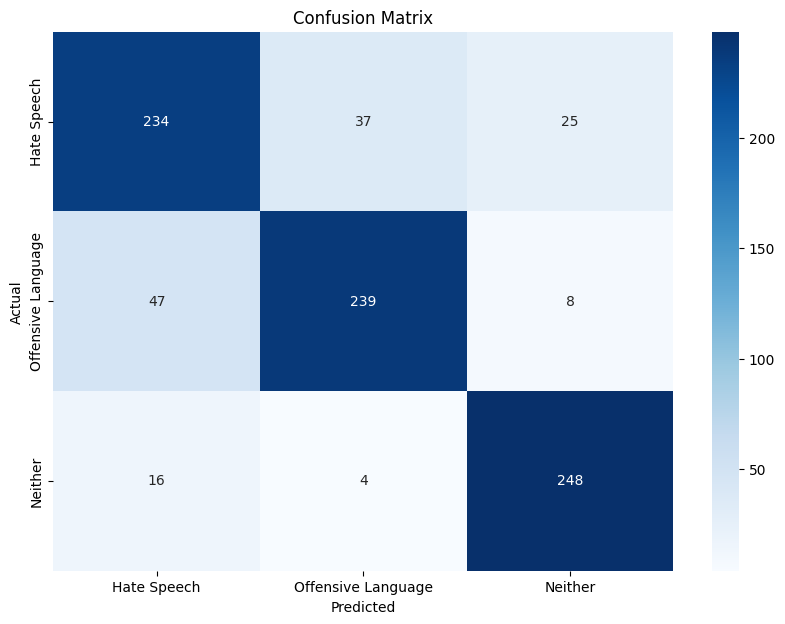

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming 'hatespeech['label']' are the true labels and 'hatespeech['predicted_label']' are the predicted labels
true_labels = test_data['label']
predicted_labels = test_data['predicted_label']

# Generating the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Labels for the classes
class_names = ['Hate Speech', 'Offensive Language', 'Neither']

# Plotting
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

### Hugging Face existing pre-trained hate-speech model
#### Source: Sakil/distilbert_lazylearner_hatespeech_detection

In [16]:
# Initialize the pipeline with the DistilBERT model
pipe = pipeline("text-classification", model="Sakil/distilbert_lazylearner_hatespeech_detection")

In [17]:
# Get predictions for the entire dataset
predictions = pipe(hatespeech['tweet'].tolist())

KeyboardInterrupt: 

In [ ]:
# Sample data for demonstration
sample_data = hatespeech['tweet'].sample(n=5, random_state=1)
sample_predictions = pipe(sample_data.tolist())

for tweet, prediction in zip(sample_data, sample_predictions):
    print(f"Tweet: {tweet}\nPrediction: {prediction}\n")

Tweet: no one goes into psychiatric to help people. those people are all immoral. everyone who works in that field is pure trash.
Prediction: {'label': 'LABEL_1', 'score': 0.8438279032707214}

Tweet: it  us ghettos-driven by liberal ideology; forged by unions &amp; bankruptcy by self-serving gems watering to parasites!trot 
Prediction: {'label': 'LABEL_1', 'score': 0.877532958984375}

Tweet: i witty wrecked a bitch.
Prediction: {'label': 'LABEL_1', 'score': 0.7545727491378784}

Tweet: oh no she didn &128129; &8220; watch to mouth bitch " one bitch and two dogs 
Prediction: {'label': 'LABEL_1', 'score': 0.786658763885498}

Tweet: it  y'all birches be like 16 looking 25 &128553;
Prediction: {'label': 'LABEL_1', 'score': 0.8328980207443237}



In [ ]:
# Assuming your model outputs string labels like 'LABEL_0', 'LABEL_1', 'LABEL_2'
label_mapping = {'LABEL_0': 0, 'LABEL_1': 1, 'LABEL_2': 2}
predicted_labels_numeric = [label_mapping[label['label']] for label in predictions]

In [ ]:
# Calculate metrics using the numeric predicted labels
accuracy = accuracy_score(hatespeech['label'], predicted_labels_numeric)
precision, recall, f1, _ = precision_recall_fscore_support(hatespeech['label'], predicted_labels_numeric, average='weighted')
conf_matrix = confusion_matrix(hatespeech['label'], predicted_labels_numeric)
report = classification_report(hatespeech['label'], predicted_labels_numeric)
mcc = matthews_corrcoef(hatespeech['label'], predicted_labels_numeric)

# Printing the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{report}")
print(f"Matthews Correlation Coefficient: {mcc}")

Accuracy: 0.34265734265734266
Precision: 0.23109681250360048
Recall: 0.34265734265734266
F1 Score: 0.2758571680949288
Confusion Matrix:
[[ 610  820    0]
 [ 570  860    0]
 [1077  353    0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.43      0.33      1430
           1       0.42      0.60      0.50      1430
           2       0.00      0.00      0.00      1430

    accuracy                           0.34      4290
   macro avg       0.23      0.34      0.28      4290
weighted avg       0.23      0.34      0.28      4290

Matthews Correlation Coefficient: 0.016171717798939125


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [1]:
pip install speechbrain


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 630.6/630.6 kB 8.0 MB/s eta 0:00:00
   ---------------------------------------- 2.4/2.4 MB 37.5 MB/s eta 0:00:00
   --------------------------------------- 198.6/198.6 MB 22.6 MB/s eta 0:00:00
   ---------------------------------------- 117.8/117.8 kB 7.2 MB/s eta 0:00:00
   ---------------------------------------- 118.0/118.0 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.1
    Uninstalling torch-2.1.1:
      Successfully uninstalled torch-2.1.1
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.16.1 requires torch==2.1.1, but you have torch 2.2.0 which is incompatible.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install nemo_toolkit['all']

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\PabloFabianFaundezGa\AppData\Roaming\Python\Python311\site-packages\pip\_vendor\packaging\requirements.py", line 102, in __init__
    req = REQUIREMENT.parseString(requirement_string)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PabloFabianFaundezGa\AppData\Roaming\Python\Python311\site-packages\pip\_vendor\pyparsing\util.py", line 256, in _inner
    return fn(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PabloFabianFaundezGa\AppData\Roaming\Python\Python311\site-packages\pip\_vendor\pyparsing\core.py", line 1190, in parse_string
    raise exc.with_traceback(None)
pip._vendor.pyparsing.exceptions.ParseException: Expected string_end, found '['  (at char 11), (line:1, col:12)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\PabloFabianFaundezGa\AppData\Roaming\Python\Python311\site-packages\

In [17]:
!pip install git+https://github.com/NVIDIA/NeMo.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/NVIDIA/NeMo.git to c:\users\pablofabianfaundezga\appdata\local\temp\pip-req-build-yfhpi9ex
  Resolved https://github.com/NVIDIA/NeMo.git to commit 8349d63f3210ca6b397ef47f8171bc5452db191c
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
INFO: pip is looking at multiple versions of nemo-toolkit to determine which version is compatible with other requirements. This could take a while.


  Running command git clone --filter=blob:none --quiet https://github.com/NVIDIA/NeMo.git 'C:\Users\PabloFabianFaundezGa\AppData\Local\Temp\pip-req-build-yfhpi9ex'
ERROR: Could not find a version that satisfies the requirement triton (from nemo-toolkit) (from versions: none)
ERROR: No matching distribution found for triton

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
# Load FastPitch
from nemo.collections.tts.models import FastPitchModel
spec_generator = FastPitchModel.from_pretrained("nvidia/tts_en_fastpitch")

# Load vocoder
from nemo.collections.tts.models import HifiGanModel
model = HifiGanModel.from_pretrained(model_name="nvidia/tts_hifigan")


ModuleNotFoundError: No module named 'nemo'

In [14]:
pip install Cython


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import soundfile as sf
parsed = spec_generator.parse("You can type your sentence here to get nemo to produce speech.")
spectrogram = spec_generator.generate_spectrogram(tokens=parsed)
audio = model.convert_spectrogram_to_audio(spec=spectrogram)

NameError: name 'spec_generator' is not defined